In [94]:
import numpy as np
import pandas as pd
import h5py
import scipy
import skimage
import matplotlib.pyplot as plt
from  PIL import Image
from scipy import ndimage
from skimage import transform
%matplotlib inline

In [5]:
train_dataset=h5py.File(r"train_catvnoncat.h5","r")
test_dataset=h5py.File(r"test_catvnoncat.h5","r")

## Data Preparation

In [6]:
train_set_x_orig=np.array(train_dataset["train_set_x"][:])
train_set_y_orig=np.array(train_dataset["train_set_y"][:])

test_set_x_orig=np.array(test_dataset["test_set_x"][:])
test_set_y_orig=np.array(test_dataset["test_set_y"][:])

In [10]:
train_set_x_orig.shape , train_set_y_orig.shape

((209, 64, 64, 3), (209,))

In [11]:
test_set_x_orig.shape , test_set_y_orig.shape

((50, 64, 64, 3), (50,))

In [14]:
classes=np.array(train_dataset["list_classes"][:])
classes

array([b'non-cat', b'cat'], dtype='|S7')

## Image Processing

In [17]:
train_set_x=train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x=test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T

train_set_x.shape , test_set_x.shape

((12288, 209), (12288, 50))

In [18]:
train_set_y=train_set_y_orig.reshape(1,train_set_y_orig.shape[0])
test_set_y=test_set_y_orig.reshape(1,test_set_y_orig.shape[0])

train_set_y.shape , test_set_y.shape

((1, 209), (1, 50))

In [20]:
train_set_x_scaled=train_set_x/255.
test_set_x_scaled=test_set_x/255.

In [89]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[2]

## Model design

In [34]:
def initialize_with_zeros(dim):
    ### START CODE HERE ### (≈ 1 line of code)
    w = np.zeros(shape=(dim, 1), dtype=np.float32)
    b = 0
    ### END CODE HERE ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [68]:
def sigmoid(z):
    f=1./(1+np.exp(-z))
    return f

In [75]:
def cost_cal( X , Y , w , b ):
    m=X.shape[1]
    
    hypo=np.dot(w.T,X)+b
    
    sigma=sigmoid(hypo)
    
    cost=(-1/m)*np.sum(Y*np.log(sigma)+(1-Y)*np.log(1-sigma),axis=1)
    
    return cost, sigma

In [76]:
def propogate( X , Y , w , b ):
    m=X.shape[1]
    
    cost, A=cost_cal(X,Y,w,b)
    
    dw = (1./m)*np.dot(X,((A-Y).T))
    db = (1./m)*np.sum(A-Y, axis=1)
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads={"dw": dw,
           "db": db}
    return cost, grads

In [77]:
def optimize( X , Y , w , b , learning_rate , iterations , print_cost=False):
    costs=[]
    
    for i in range(iterations):
        cost, grads=propogate(X,Y,w,b)
        
        w=w-learning_rate*grads["dw"]
        
        b=b-learning_rate*grads["db"]
        
        if i%100==0:
            costs.append(cost)
        if print_cost and i%100==0:
            print ("Cost after iteration %i: %f" %(i, cost))
        
    parameters={"w": w,
                "b": b}
    
    return parameters, costs

In [90]:
def prediction( X , w , b):
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    hypo=np.dot(w.T,X)+b
    
    sigma=sigmoid(hypo)
    
    for j in range(sigma.shape[1]):
        
        if sigma[0,j]>0.5:
            Y_prediction[0,j]=1
        
        else:
            Y_prediction[0,j]=0
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [91]:
def model(X_train , Y_train , X_test, Y_test, learning_rate, iterations , print_cost=False):
    
    w, b = initialize_with_zeros(X_train.shape[0])
    
    parameters, costs=optimize(X_train,Y_train,w,b,learning_rate,iterations,print_cost)
    
    w = parameters["w"]
    b = parameters["b"]
    
    Y_predict_test = prediction( X_test,w,b)
    Y_predict_train = prediction( X_train,w,b)
    
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_predict_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_predict_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_predict_test, 
         "Y_prediction_train" : Y_predict_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": iterations}
    
    return d

In [101]:
d = model(train_set_x_scaled, train_set_y, test_set_x_scaled, test_set_y, iterations = 2000, learning_rate = 0.001, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.591289
Cost after iteration 200: 0.555796
Cost after iteration 300: 0.528977
Cost after iteration 400: 0.506881
Cost after iteration 500: 0.487880
Cost after iteration 600: 0.471108
Cost after iteration 700: 0.456046
Cost after iteration 800: 0.442350
Cost after iteration 900: 0.429782
Cost after iteration 1000: 0.418164
Cost after iteration 1100: 0.407362
Cost after iteration 1200: 0.397269
Cost after iteration 1300: 0.387802
Cost after iteration 1400: 0.378888
Cost after iteration 1500: 0.370471
Cost after iteration 1600: 0.362500
Cost after iteration 1700: 0.354934
Cost after iteration 1800: 0.347737
Cost after iteration 1900: 0.340877
train accuracy: 91.38755980861244 %
test accuracy: 68.0 %


## Evaluation

y = 1, you predicted that it is a "cat" picture.


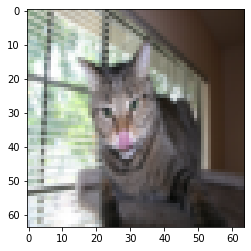

In [103]:
index=20
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(d["Y_prediction_test"][0,index])].decode("utf-8") +  "\" picture.")

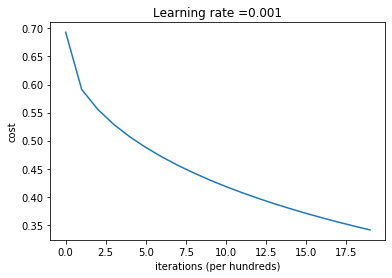

In [102]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



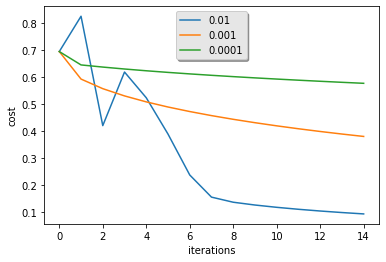

In [97]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x_scaled, train_set_y, test_set_x_scaled, test_set_y, iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

y = 1.0, your algorithm predicts a "cat" picture.


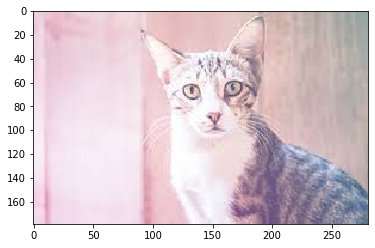

In [100]:
my_image = "images/c2.jpg"    #change this to the name of your image file 

# We preprocess the image to fit your algorithm.
fname = r"C:\Users\user\Desktop\dl work/" + my_image
image = np.array(plt.imread(fname))
my_image = skimage.transform.resize(image, output_shape=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = prediction( my_image,d["w"], d["b"])

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")